In [18]:
import os

import numpy as np
from numpy import fft
import pyfftw
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from scipy.signal.windows import tukey

#import tensorflow as tf
#print("Is GPU available:", tf.config.list_physical_devices('GPU'))

import camb

from tqdm import tqdm

In [2]:
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator, MaxNLocator
import matplotlib as mpl

# define matplotlib style
mpl.style.use('classic')
mpl.rc('xtick', labelsize=23); mpl.rc('ytick', labelsize=23)
mpl.rc('xtick.major', size=15 , width=2)
mpl.rc('xtick.minor', size=8, width=2, visible=True)
mpl.rc('ytick.major', size=15 , width=2)
mpl.rc('ytick.minor', size=8, width=2, visible=True)
mpl.rc('lines',linewidth=3, markersize=20)
mpl.rc('axes', linewidth=2, labelsize=30, labelpad=2.5)
mpl.rc('legend', fontsize=25, loc='best', frameon=False, numpoints=1)

mpl.rc('font', family='STIXGeneral')
mpl.rc('mathtext', fontset='stix')

In [3]:
def inspect_array(array,log=False,exclude_nan=False):
        '''
        Helper function to inspect the array.
        '''
        print(' Shape:', array.shape)

        array = np.log10(array) if log else array

        print(' Min:', np.nanmin(array) if exclude_nan else np.min(array))
        print(' Max:', np.nanmax(array) if exclude_nan else np.max(array))
        print(' Mean:', np.nanmean(array) if exclude_nan else np.mean(array))
        print(' Std:', np.nanstd(array) if exclude_nan else np.std(array))

In [4]:
data = np.load('../cmb_analysis_pset_data.npz')

In [5]:
pixel_size = 0.0005236
delta_t = 1

In [6]:
list(data.keys())

['test_signal',
 'test_white_noise',
 'test_red_noise',
 'test_x',
 'test_y',
 'data_small_1',
 'x_small_1',
 'y_small_1',
 'data_small_2',
 'x_small_2',
 'y_small_2',
 'data_large_1',
 'x_large_1',
 'y_large_1',
 'data_large_2',
 'x_large_2',
 'y_large_2',
 'data_really_large_1',
 'x_really_large_1',
 'y_really_large_1',
 'data_really_large_2',
 'x_really_large_2',
 'y_really_large_2']

In [7]:
class NoisePointingModel:
    """Represents the pointing operator and noise matrix.

    Parameters
    ----------
    x : 1D array of data length
        x pixel index (will be rounded to an integer). Values must be between 0 and nx - 1.
    y : 1D array of data length
        y pixel index (will be rounded to an integer). Values must be between 0 and ny - 1.
    nx : int
        Map size in x direction
    ny : int
        Map size in y direction
    noise_spec: 1D array
        Noise power spectrum. Length should be the same as `fft.rfft(data)`. Entries
        should be an estimate of < abs(rfft(data))**2 > / len(data).

    """

    def __init__(self, x, y, nx, ny, noise_spec):
        self._x = np.round(x).astype(int)
        self._y = np.round(y).astype(int)
        self._nx = nx
        self._ny = ny
        self._flat_inds = self._y + ny * self._x
        self._noise_spec = noise_spec.copy()
        # Replace the 0-frequency (mean mode) with twice the fundamental (frequency 1).
        self._noise_spec[0] = noise_spec[1] * 2

    def apply_noise_weights(self, data):
        """Noise weight a time-order-data array.

        Performs the operation $N^{-1} d$.

        """

        # Note that I don't need unitary normalizations for the FFTs since the normalization
        # factors cancel between the forward and inverse FFT. However, the noise power
        # spectrum must be normalized to be that of the unitary case.
        fdata = fft.rfft(data)
        fdata /= self._noise_spec
        #fdata[0] = 0
        return fft.irfft(fdata)
    
    def grid_data(self, data, out):
        """Accumulate time-order data into a map.

        Performs the operation 


        For performance reasons, output must be preallocated.
        It should be an array with shape (nx, ny).

        80% of the the runtime of the function `noise_ing_to_map_domain`
        is calling this function but I can't think of a simple way to
        speed it up.

        """

        #out = np.zeros((self._nx, self._ny), dtype=float)
        np.add.at(out, (self._x, self._y), data)
        return out

    def map_noise_inv(self):
        """Calculate the map noise inverse matrix.

        Performs the operation 


        Returns
        -------
        CN : 4D array with shape (nx, ny, nx, ny)

        """

        nx = self._nx
        ny = self._ny
        out = np.zeros((nx, ny, nx, ny), dtype=np.float32)
        colP = pyfftw.empty_aligned(len(self._x), dtype=np.float32)
        for ii in tqdm(range(nx)):
            for jj in range(ny):
                #t0 = time.time()
                colP[:] = np.logical_and(self._x == ii, self._y == jj)
                #t1 = time.time() - t0
                colP[:] = self.apply_noise_weights(colP)
                #t2 = time.time() - t0
                self.grid_data(colP, out[ii, jj])
                #t3 = time.time() - t0
                #print(t1, t2, t3)
        return out

In [8]:
class DataSet:
    def __init__(self,
                 data,
                 x,y,
                 nx,ny,
                 pixel_size=pixel_size,
                 delta_t=delta_t,
                 noise_spec_bins=256):
        self.data = data

        self.nx = nx
        self.ny = ny

        self.pixel_size = pixel_size
        self.x = np.round(x / pixel_size).astype(int)
        self.y = np.round(y / pixel_size).astype(int)

        self.delta_t = delta_t
        self.noise_spec_bins = noise_spec_bins
        self.noise_spec = self._noise_spec(delta_t,noise_spec_bins)

        self.noise_model = NoisePointingModel(self.x, self.y, self.nx, self.ny, self.noise_spec)

    def _noise_spec(self,delta_t,bins):
        nps_raw = np.abs(fft.rfft(self.data))**2/self.data.shape[0]
        omegas = 2*np.pi * fft.rfftfreq(self.data.shape[0],delta_t)
        omega_avg = omegas[::bins]
        nps_avg = nps_raw[:-1].reshape(-1,bins).mean(axis=-1)
        return interp1d(omega_avg,np.append(nps_avg,nps_avg[-1]))(omegas)

    def grid_data(self, data):
        reshape_data = np.zeros((self.nx, self.ny), dtype=float)
        np.add.at(reshape_data, (self.x, self.y), data)
        return reshape_data

    def denoise_data(self):
        noise_weighted_data = self.noise_model.apply_noise_weights(self.data)
        grid_data = self.grid_data(noise_weighted_data)
        
        CN_inv = self.noise_model.map_noise_inv().reshape((self.nx*self.ny,self.nx*self.ny))
        # if tf.config.list_physical_devices('GPU'):
        #     with tf.device('/device:GPU:0'):
        #         CN = tf.linalg.inv(CN_inv)
        # else:
        CN = np.linalg.inv(CN_inv)

        denoised_grid_data = np.matmul(CN,grid_data.flatten()).reshape((self.nx,self.ny))

        return denoised_grid_data

    def show_map(self,grid_data,save_file=None):
        nx, ny = grid_data.shape
        if nx == ny:
            fig, ax = plt.subplots(figsize=(7,7))
        else:
            fig, ax = plt.subplots(figsize=(nx/ny*7,7))

        ax.imshow(grid_data.T, cmap='RdBu', origin='lower', interpolation='nearest')

        ax.set_xlabel('x [pixels]')
        ax.set_ylabel('y [pixels]')

        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))

        plt.tight_layout()
        if save_file:
            plt.savefig(save_file)

        plt.show()

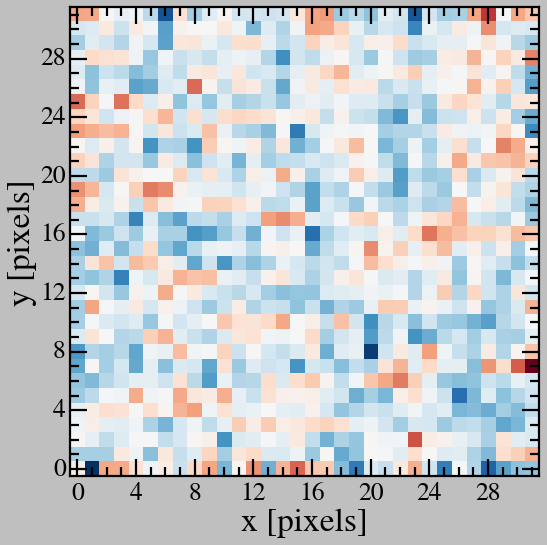

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:10<00:00,  3.08it/s]


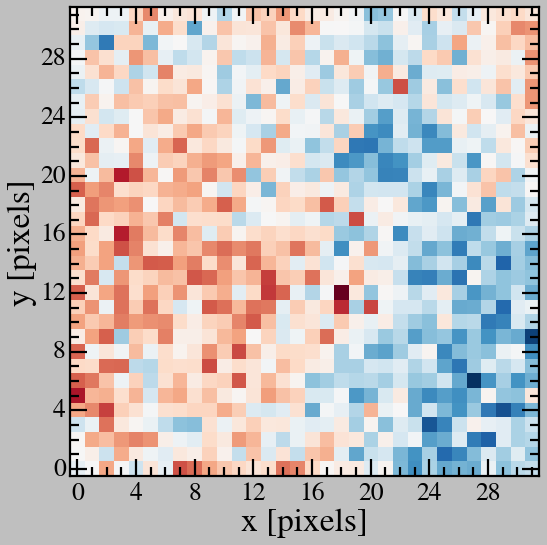

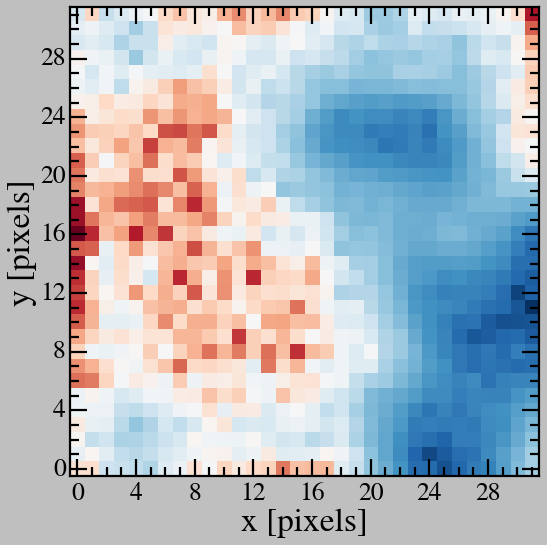

In [9]:
test_dataset = DataSet(
    data['test_signal'] + data['test_white_noise'] + data['test_red_noise'],
    data['test_x'],data['test_y'],
    32,32,
    noise_spec_bins=32
)

test_dataset.show_map(test_dataset.grid_data(test_dataset.data))

denoised_grid_data = test_dataset.denoise_data()
test_dataset.show_map(denoised_grid_data)

test_signal = DataSet(
    data['test_signal'],
    data['test_x'],data['test_y'],
    32,32,
)

test_signal.show_map(test_signal.grid_data(test_signal.data))

In [ ]:
data_sizes = {
    'small' : (128,32),
    'large' : (256,64),
    'really_large' : (512,128),
}

processed_data_dir = 'processed_data/'
visualizations_dir = 'processed_data/visualizations/'

for data_size in data_sizes:
    for i in range(1,3):
        identifier = f'{data_size}_{i}'
        if os.path.exists(f'{processed_data_dir}/{identifier}.npy'):
            denoised_grid_data = np.load(f'{processed_data_dir}/{identifier}.npy')
            test_dataset.show_map(denoised_grid_data)

            print(f'{identifier} already processed')
            continue

        dataset = DataSet(
            data[f'data_{identifier}'],
            data[f'x_{identifier}'],data[f'y_{identifier}'],
            *data_sizes[data_size],
            noise_spec_bins=data_sizes[data_size][1])
        
        denoised_grid_data = dataset.denoise_data()
        np.save(f'{processed_data_dir}/{identifier}.npy',denoised_grid_data,allow_pickle=True)

        dataset.show_map(denoised_grid_data,f'{visualizations_dir}/{identifier}.png')
        print(f'{identifier} processed')

In [14]:
def naive_PS_estimator(map1, map2, pix_size, l_bin_edges):
    """A simple angular power spectrum estimator.

    Implements the power spectrum estimator in 2D. This
    is sub-optimal because it does not know about the correlations in the noise. It is
    also wrong on large scales since it assumes a map with periodic boundary conditions.

    Parameters
    ----------
    map1 : 2D array
        Map 1
    map2 : 2D array
        Map 2
    pix_size : float
        Pixel size in radians.
    l_bin_edges : 1d array len n_l + 1
        Edges of the multipole (l) bins. The number of bins will be n_l = len(l_bin_edges)-1

    Returns
    -------
    Cl : 1d array len n_l
        Angular power spectrum estimate
    Cl_var : 1d array len n_l
        variance of angular power spectrum estimate
    n_modes : 1d array len n_l
        Number of modes in each bin

    """
    
    # performs windowing
    alpha = 0.2
    num_rows = len(map1)
    num_cols = len(map1[0])
    tukey_rows = tukey(num_rows, alpha = alpha, sym = False)
    tukey_cols = tukey(num_cols, alpha = alpha, sym = False)
    power_change_factor = 0
    for i in range(len(map1)):
        for j in range(len(map1[0])):
            map1[i][j] *= tukey_rows[i] * tukey_cols[j]
            map2[i][j] *= tukey_rows[i] * tukey_cols[j]
            power_change_factor += tukey_rows[i] * tukey_cols[j]
    power_change_factor /= (num_rows * num_cols)
            
    # code kiyo gave us
    al1 = fft.fft2(map1) * pix_size**2
    al2 = fft.fft2(map2) * pix_size**2
    Cl_2D_11 = abs(al1)**2
    Cl_2D_22 = abs(al2)**2
    Cl_2D_12 = np.real(al1.conj() * al2)
    lx = fft.fftfreq(map1.shape[0], pix_size) * 2 * np.pi
    ly = fft.fftfreq(map1.shape[1], pix_size) * 2 * np.pi
    l = np.sqrt(lx[:, None]**2 + ly**2)
    Cl_11 = np.zeros(len(l_bin_edges) - 1)
    Cl_22 = np.zeros_like(Cl_11)
    Cl_12 = np.zeros_like(Cl_11)
    n_modes = np.zeros(len(l_bin_edges) - 1)
    for ii in range(len(l_bin_edges) - 1):
        ledge_l = l_bin_edges[ii]
        ledge_h = l_bin_edges[ii + 1]
        m = np.logical_and(l < ledge_h, l >= ledge_l)
        Cl_11[ii] += np.sum(Cl_2D_11[m])
        Cl_22[ii] += np.sum(Cl_2D_22[m])
        Cl_12[ii] += np.sum(Cl_2D_12[m])
        n_modes[ii] += np.sum(m)
    Cl_11 /= (n_modes * map1.size * pix_size**2)
    Cl_22 /= (n_modes * map1.size * pix_size**2)
    Cl_12 /= (n_modes * map1.size * pix_size**2)
    Cl_12_var = (Cl_11*Cl_22 + Cl_12**2) / n_modes
    return Cl_12 / power_change_factor, n_modes, Cl_12_var / power_change_factor

def run_camb(h, ombh2, omch2, lnAs, ns):
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=100 * h, ombh2=ombh2, omch2=omch2, mnu=0.06, omk=0, tau=0.06)
    pars.InitPower.set_params(As=np.exp(lnAs), ns=ns, r=0)
    pars.set_for_lmax(2000, lens_potential_accuracy=0)
    pars.WantTensors = False
    pars.WantTransfer = False
    pars.DoLensing = False
    pars.DoLateRadTruncation = True
    results = camb.get_results(pars)
    powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
    DlTT = powers['total'][:, 0]
    ell = np.arange(DlTT.shape[0])
    return ell, DlTT

In [20]:
class PowerSpectrum:
    def __init__(self, 
                 grid_data_1, grid_data_2,
                 pixel_size=pixel_size,
                 l_bin_edges=np.linspace(40, 2040, 40)):
        
        self.pixel_size = pixel_size
        self.l_bin_edges = l_bin_edges
        self.l = (l_bin_edges[1:] + l_bin_edges[:-1]) / 2
        
        self.Cl, self.n_modes, self.Cl_var = naive_PS_estimator(grid_data_1, grid_data_2, pixel_size, l_bin_edges)
        
        self._apply_nan_mask()
        self.Dl = self.l * (self.l + 1) * self.Cl / (2 * np.pi)
        self.Dl_err = self.l * (self.l + 1) * np.sqrt(self.Cl_var) / (2 * np.pi)

    def _apply_nan_mask(self):
        nan_mask = np.logical_or(
            np.isnan(self.Cl),
            np.isnan(self.n_modes),
            np.isnan(self.Cl_var),
        )
        self.l = self.l[~nan_mask]
        self.Cl = self.Cl[~nan_mask]
        self.n_modes = self.n_modes[~nan_mask]
        self.Cl_var = self.Cl_var[~nan_mask]

    def model_spectrum(self, params):
        theta_beam = 0.00088934    # radians
        ell, DlTT = run_camb(*params)
        DlTT *= np.exp(-1 * ell ** 2 * theta_beam ** 2 / 2) ** 2    # accounts for finite telescope resolution
        return interp1d(ell, DlTT)(self.l)
    
    def chi2(self, params):
        model_Dl = self.model_spectrum(params)
        return np.sum((self.Dl - model_Dl)**2 / self.Dl_err**2)
    
    def fit(self, initial_guess):
        result = minimize(self.chi2, initial_guess, method='Nelder-Mead', options={'maxiter':10000})
        return {
            'params': result.x,

            'NLL' : result.fun,

            'success': result.success,
            'message': result.message
        }

    def show_power_spectrum(self,best_fit_params=None,save_file=None):
        fig, ax = plt.subplots(figsize=(9,7))

        ax.errorbar(self.l, self.Dl, self.Dl_err, color='darkcyan', fmt=' ', elinewidth=2, capsize=5, capthick=2, label='Data')
        if best_fit_params is not None:
            ax.plot(self.l, self.model_spectrum(best_fit_params), color='indianred', label='Best Fit')
            ax.legend()

        ax.set_xlim(0,2000)
        ax.set_ylim(0,6000)

        ax.set_xlabel(r'$\ell$')
        ax.set_ylabel(r'$D_{\ell}$')

        plt.tight_layout()
        if save_file:
            plt.savefig(save_file)

        plt.show()

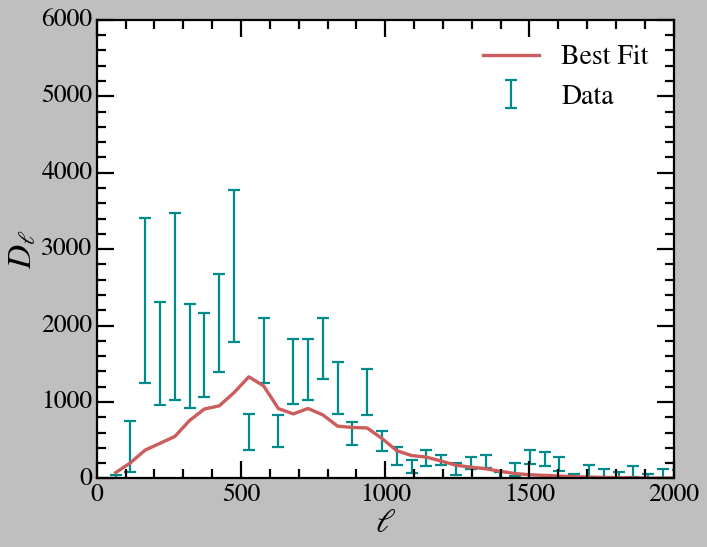

In [22]:
data_sizes = {
    #'small' : (128,32),    # suboptimal statistics so we don't use
    'large' : (256,64),
    #'really_large' : (512,128),    # making this map was too computationally expensive
}

for data_size in data_sizes:
    if not os.path.exists(f'{processed_data_dir}/{data_size}_1.npy') and not os.path.exists(f'{processed_data_dir}/{data_size}_2.npy'):
        print(f'{data_size} dataset not processed')
        continue

    power_spectrum = PowerSpectrum(
        np.load(f'{processed_data_dir}/{data_size}_1.npy'),
        np.load(f'{processed_data_dir}/{data_size}_2.npy')
    )

    fit_results = power_spectrum.fit([0.7, 0.022, 0.12, 3.0, 0.96])
    if not fit_results['success']:
        print(f'{data_size} fit failed')
        print(fit_results['message'])
        continue

    best_fit_params = fit_results['params']

    power_spectrum.show_power_spectrum(best_fit_params,f'{visualizations_dir}/{data_size}_power_spectrum.png')

In [23]:
print(best_fit_params)

[ 2.51417221e+00  1.10990546e-02  6.66595503e-01 -2.13342189e+01
  2.88113318e+00]
